In [1]:
import ast
import json
import os
import re
import shutil
import sys
import warnings
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output
from numba import cuda
from PIL import Image
from tensorflow import keras
from tqdm import tqdm

from src.test_utils.test_utils import Generator, Test

# warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

In [11]:
for file in os.listdir('/app/_data/train_npy_600/'):
    f = np.load('/app/_data/train_npy_600/'+file)
    a = f[:,:,0]
    np.save('/app/_data/npy_600_1/'+file[:-4], a)

In [12]:
len(os.listdir('/app/_data/npy_600_1/'))

6030

In [13]:
shutil.make_archive('train_npy_1d','zip','/app/_data/npy_600_1/')

'/app/sandbox/test/train_npy_1d.zip'

In [2]:
sample_submission = pd.read_csv("/app/_data/sample_submission.csv")
if sample_submission.shape[0] == 2477:
    TRAIN_MODE = True
else:
    TRAIN_MODE = False
IMG_FROM_FOLDER = True
OBJ_DET = True
CLASSIFICATION = True
TRAIN_MODE

True

In [3]:
TEST_PATH = "/app/_data/test/"
TEST_JPG_PATH = "/app/_data/tmp/"
METADATA_PATH = "/app/_data//dict_metadata.json"
MODEL_PATH = [
    "/app/_data/models/EffB7_init/",
]
MODEL_2CL_PATH = [
    "/app/_data/models/EffB7_2class_1/EffB7_2cl_1.h5",
    "/app/_data/models/EffB7_2class_1/EffB7_2cl_3.h5",
    "/app/_data/models/EffB7_2class_1/EffB7_2cl_4.h5",
]
SAVE_BBOX_PATH = "/app/_data/tmp/labels/"

with open(METADATA_PATH, "r") as f:
    dict_metadata = json.load(f)
labels = {v: k for k, v in dict_metadata["class"].items()}
labels

{0: 'negative', 1: 'typical', 2: 'indeterminate', 3: 'atypical'}

In [4]:
# shutil.rmtree("/app/_data/tmp/")
test_df = Test.prepare_data(
    data_path=TEST_PATH,
    path_to_save=TEST_JPG_PATH,
    train_mode=TRAIN_MODE,
    n_train_sample=10,
    jpg=True
)
test_df.head()

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]
/app/src/test_utils/test_utils.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["path"] = test_df["path"].str.replace("\../", "/kaggle/")


,path,StudyInstanceUID,id_image,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height
0,/app/_data/test/fe64182ae21d/d56579abcb25/a82c...,fe64182ae21d,a82ca8f37fb6,CR,F,CHEST,MONOCHROME2,4248.0,3480.0
1,/app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...,6117058c3931,b74f81d65e79,DX,M,CHEST,MONOCHROME2,3032.0,3032.0
2,/app/_data/test/b83eaac8a377/326c25201eea/1c13...,b83eaac8a377,1c13336fc8a9,DX,M,CHEST,MONOCHROME2,3032.0,2520.0
3,/app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...,9fab41ffbc39,fa0c84ee4577,CR,F,CHEST,MONOCHROME1,4240.0,3480.0
4,/app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...,4e4ee0341fab,dc6834a1efa6,CR,F,CHEST,MONOCHROME2,2621.0,2597.0


In [5]:
os.listdir('/app/_data/tmp/')

['36ba388a18df.jpg',
 'fa0c84ee4577.jpg',
 '64ea82b1343f.png',
 '64ea82b1343f.jpg',
 'eff9f15c7e9b.png',
 'acc3e6eff7c8.png',
 'dc6834a1efa6.png',
 '36ba388a18df.png',
 '87d8baf120a6.png',
 '1c13336fc8a9.jpg',
 'dc6834a1efa6.jpg',
 'fa0c84ee4577.png',
 'acc3e6eff7c8.jpg',
 'b74f81d65e79.png',
 'a82ca8f37fb6.png',
 'a82ca8f37fb6.jpg',
 '87d8baf120a6.jpg',
 'eff9f15c7e9b.jpg',
 'b74f81d65e79.jpg',
 '1c13336fc8a9.png']

In [17]:
for img_name in test_df.id_image.tolist():
    img = tf.io.read_file('/app/_data/tmp/' + img_name + ".png")
    img = tf.image.decode_png(img, channels=3)
    img_jpg = tf.io.read_file('/app/_data/tmp/' + img_name + ".jpg")
    img_jpg = tf.image.decode_jpeg(img_jpg, channels=3)
    img = tf.image.resize(
        img,
        (600, 600),
    )
    img = tf.cast(img, tf.uint8)
    img = img.numpy()
    img_jpg = tf.image.resize(
        img_jpg,
        (600, 600),
    )
    img_jpg = tf.cast(img_jpg, tf.uint8)
    img_jpg = img_jpg.numpy()
    print(np.sum(img==img_jpg), img.max(), img.min(), img_jpg.max(), img_jpg.min())

359109 230 0 225 0
321834 254 0 255 0
270942 255 0 255 0
279249 204 0 199 0
224685 246 0 244 0
678192 254 0 254 0
254400 255 0 255 0
437775 255 1 255 0
345678 255 0 255 0
212094 254 0 249 0


In [ ]:
              if self.png:
                    img = tf.io.read_file(self.jpg_path + img_name + ".png")
                    img = tf.image.decode_png(img, channels=3)
                elif self.jpg:
                    img = tf.io.read_file(self.jpg_path + img_name + ".jpg")
                    img = tf.image.decode_jpeg(img, channels=3)
                img = tf.cast(img, tf.float32) / 255.0
                img = tf.image.resize(
                    img,
                    (self.img_size, self.img_size),
                ) * 255
                img = tf.cast(img, tf.uint8)
                img = img.numpy()

(1, 600, 600, 3)


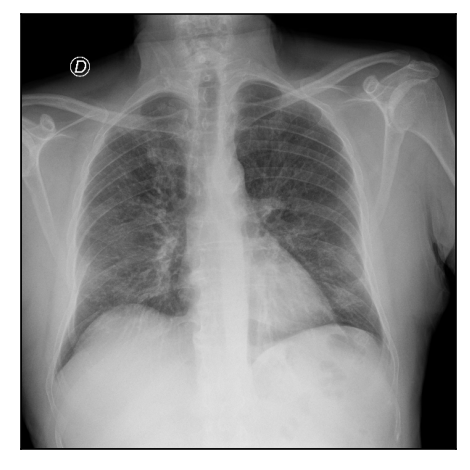

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


100%|██████████| 51/51 [01:47<00:00,  2.11s/it]


,id,PredictionString
0,00be7de16711_study,negative 0.05375 0 0 1 1 typical 0.69109 0 0 1...
1,0b6af2d5fa06_study,negative 0.97679 0 0 1 1 typical 0.00466 0 0 1...
2,0fa7372c4120_study,negative 0.00155 0 0 1 1 typical 0.94755 0 0 1...
3,163abcbc5d4a_study,negative 0.06985 0 0 1 1 typical 0.52994 0 0 1...
4,18acddb9abb7_study,negative 0.96296 0 0 1 1 typical 0.0071 0 0 1 ...
5,1d7b78acc1ff_study,negative 0.31798 0 0 1 1 typical 0.15568 0 0 1...
6,1d8b4a15135f_study,negative 0.70565 0 0 1 1 typical 0.02494 0 0 1...
7,1f816ad2d311_study,negative 0.00037 0 0 1 1 typical 0.84192 0 0 1...
8,21119216b217_study,negative 0.22442 0 0 1 1 typical 0.08827 0 0 1...
9,215d5a459a13_study,negative 0.00061 0 0 1 1 typical 0.99168 0 0 1...


,path,StudyInstanceUID,id_image,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,negative,typical,indeterminate,atypical,negative_2cl
0,/app/_data/test/fe64182ae21d/d56579abcb25/a82c...,fe64182ae21d,a82ca8f37fb6,CR,F,CHEST,MONOCHROME2,4248.0,3480.0,0.018876,0.767393,0.120930,0.080063,0.005692
1,/app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...,6117058c3931,b74f81d65e79,DX,M,CHEST,MONOCHROME2,3032.0,3032.0,0.006079,0.899384,0.100281,0.030940,0.021530
2,/app/_data/test/b83eaac8a377/326c25201eea/1c13...,b83eaac8a377,1c13336fc8a9,DX,M,CHEST,MONOCHROME2,3032.0,2520.0,0.002575,0.837961,0.314782,0.107710,0.000937
3,/app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...,9fab41ffbc39,fa0c84ee4577,CR,F,CHEST,MONOCHROME1,4240.0,3480.0,0.003786,0.961311,0.053046,0.008459,0.000072
4,/app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...,4e4ee0341fab,dc6834a1efa6,CR,F,CHEST,MONOCHROME2,2621.0,2597.0,0.168862,0.020496,0.129497,0.608383,0.474854
5,/app/_data/test/5a74a91d9877/25998b541988/eff9...,5a74a91d9877,eff9f15c7e9b,DX,M,TORAX,MONOCHROME2,3712.0,3395.0,0.034563,0.758463,0.145910,0.040297,0.000218
6,/app/_data/test/e43ccd956545/64ed4d9be391/87d8...,e43ccd956545,87d8baf120a6,CR,M,CHEST,MONOCHROME2,4240.0,3480.0,0.005102,0.652132,0.212211,0.067729,0.004105
7,/app/_data/test/a8fe3043e449/73453ff7181d/64ea...,a8fe3043e449,64ea82b1343f,DX,M,CHEST,MONOCHROME2,4256.0,3488.0,0.021226,0.563361,0.218275,0.104258,0.007504
8,/app/_data/test/1d8b4a15135f/cfe99f0be9cb/acc3...,1d8b4a15135f,acc3e6eff7c8,DX,M,CHEST,MONOCHROME2,2979.0,2837.0,0.705646,0.024936,0.060422,0.223057,0.633789
9,/app/_data/test/994aa93b88d6/2138dd9d65e4/36ba...,994aa93b88d6,36ba388a18df,CR,M,CHEST,MONOCHROME2,4248.0,3480.0,0.000487,0.906468,0.092248,0.008052,0.000882


In [5]:
tf.keras.backend.clear_session()

if not OBJ_DET:
    sub_study, sub_image, test_df = Test.make_classification(
        test_df_=test_df,
        jpg_path=TEST_JPG_PATH,
        metadata_path=METADATA_PATH,
        model_path=MODEL_PATH,
        labels=labels,
        img_from_folder=IMG_FROM_FOLDER,
        obj_det=OBJ_DET,
        classification=CLASSIFICATION,
        img_size=600,
        model_2cl_path=MODEL_2CL_PATH,
        n_inputs=2,
    )
    sub_image.head()
else:
    sub_study, test_df = Test.make_classification(
        test_df_=test_df,
        jpg_path=TEST_JPG_PATH,
        metadata_path=METADATA_PATH,
        model_path=MODEL_PATH,
        labels=labels,
        img_from_folder=IMG_FROM_FOLDER,
        obj_det=OBJ_DET,
        classification=CLASSIFICATION,
        img_size=600,
        model_2cl_path=MODEL_2CL_PATH,
        n_inputs=2,
    )
sub_study.head(10)
test_df.head(10)

In [9]:
gen2 = Generator(
    df=test_df,
    img_size=600,
    jpg_path=TEST_JPG_PATH,
    metadata_path=METADATA_PATH,
    img_from_folder=True,
    batch_size=1,
    n_inputs=2,
)

In [18]:
g = gen2.__getitem__(8)

In [19]:
g

{'img': array([[[[ 17,  17,  17],
          [ 17,  17,  17],
          [ 17,  17,  17],
          ...,
          [  7,   7,   7],
          [  6,   6,   6],
          [  9,   9,   9]],
 
         [[ 12,  12,  12],
          [ 12,  12,  12],
          [ 12,  12,  12],
          ...,
          [  7,   7,   7],
          [  6,   6,   6],
          [  9,   9,   9]],
 
         [[  9,   9,   9],
          [  9,   9,   9],
          [  9,   9,   9],
          ...,
          [  7,   7,   7],
          [  8,   8,   8],
          [  6,   6,   6]],
 
         ...,
 
         [[  1,   1,   1],
          [251, 251, 251],
          [249, 249, 249],
          ...,
          [156, 156, 156],
          [152, 152, 152],
          [156, 156, 156]],
 
         [[  4,   4,   4],
          [  6,   6,   6],
          [  0,   0,   0],
          ...,
          [166, 166, 166],
          [161, 161, 161],
          [160, 160, 160]],
 
         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   

In [12]:
mod_path = "/app/_data/models/EffB7_2class_1/"
m = []
for file in os.listdir(mod_path):
    if ".h5" in file:
        print(file)
        m.append(keras.models.load_model(mod_path + file))

EffB7_2cl_2.h5
EffB7_2cl_1.h5
EffB7_2cl_0.h5
EffB7_2cl_4.h5
EffB7_2cl_3.h5


In [20]:
m[0](g).numpy()[0]
m[1](g).numpy()[0]
m[2](g).numpy()[0]
m[3](g).numpy()[0]
m[4](g).numpy()[0]

array([0.931  , 0.06903], dtype=float16)

array([0.517, 0.483], dtype=float16)

array([0.79176676, 0.20823325], dtype=float32)

array([0.478, 0.522], dtype=float16)

array([0.906  , 0.09436], dtype=float16)

In [5]:
(0.517 + 0.478 + 0.906) / 3

0.6336666666666667

In [ ]:
(m[1](g).numpy()[0][0] + m[3](g).numpy()[0][0] + m[4](g).numpy()[0][0]) / 3

In [21]:
c = np.mean([model(g).numpy()[0][0] for model in m])
c

0.7247596

In [13]:
([model(g).numpy()[0] for model in m])

[array([0.6943, 0.3057], dtype=float16),
 array([0.719, 0.281], dtype=float16),
 array([0.2816995, 0.7183005], dtype=float32),
 array([0.006462, 0.9937  ], dtype=float16),
 array([0.699, 0.301], dtype=float16)]

In [17]:
(0.6943 + 0.719 + 0.2816995 + 0.006462 + 0.699) / 5

0.4800923

In [18]:
MODEL_PATH = "/app/_data/models/EffB7_init/"
m = []
for file in os.listdir(MODEL_PATH):
    if ".h5" in file:
        print(file)
        m.append(keras.models.load_model(MODEL_PATH + file))

EffB7_3.h5
EffB7_0.h5
EffB7_1.h5
EffB7_2.h5


In [20]:
m[0](g).numpy()[0]
m[1](g).numpy()[0]
m[2](g).numpy()[0]
m[3](g).numpy()[0]

array([0.00684637, 0.00405944, 0.01655805, 0.7818206 ], dtype=float32)

array([0.02202711, 0.03989942, 0.26228774, 0.6006486 ], dtype=float32)

array([0.00126375, 0.00234046, 0.0095786 , 0.9861438 ], dtype=float32)

array([0.6453095 , 0.03568565, 0.2295647 , 0.06491929], dtype=float32)

In [23]:
c = np.mean([model(g).numpy()[0] for model in m], axis=0)
c

array([0.16886169, 0.02049624, 0.12949727, 0.60838306], dtype=float32)

# yolo

In [6]:
%cd /app/_data/ScaledYOLOv4/mish-cuda
!python setup.py build install
%cd /app/_data/ScaledYOLOv4

/app/_data/ScaledYOLOv4/mish-cuda
running build
running build_py
running egg_info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:352: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
reading manifest file 'src/mish_cuda.egg-info/SOURCES.txt'
writing manifest file 'src/mish_cuda.egg-info/SOURCES.txt'

running build_ext
running install
running bdist_egg
installing library code to build/bdist.linux-x86_64/egg
running install_lib
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mish_cuda
copying build/lib.linux-x86_64-3.8/mish_cuda/_C.cpython-38-x86_64-linux-gn

In [7]:
device = cuda.get_current_device()
device.reset()

In [8]:
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt \
                  /app/_data/yolov4p7weights/only_c_0_42_b.pt \
                  --source /app/_data/tmp \
                  --img-size 1024 \
                  --conf-thres 0.3 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.3, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels/', save_txt=True, source='/app/_data/tmp', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/only_c_0_42_b.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24265MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Ensemble created with ['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/only_c_0_42_b.pt']

image 1/101 /app/_data/tmp/05e168e0d636.jpg: 1024x1024 Done. (0.428s)
image 2/101 /app/_data/tmp/079be2a10982.jpg: 896x1024 Done. (0.438s)
image 3/101 /app/_data/tmp/09b64291b1b9.jpg: 1024x1024 Done. (0.414s)
image 4/101 /app/_data/tmp/11b8e5179115.j

In [15]:
test_df = test_df[test_df.columns[:-1]]
test_df

,path,StudyInstanceUID,id_image,modality,PatientSex,BodyPartExamined,PhotometricInterpretation,width,height,negative,typical,indeterminate,atypical
0,/app/_data/test/fe64182ae21d/d56579abcb25/a82c...,fe64182ae21d,a82ca8f37fb6,CR,F,CHEST,MONOCHROME2,4248.0,3480.0,0.018855,0.767745,0.121190,0.077865
1,/app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...,6117058c3931,b74f81d65e79,DX,M,CHEST,MONOCHROME2,3032.0,3032.0,0.005985,0.900126,0.099915,0.030893
2,/app/_data/test/b83eaac8a377/326c25201eea/1c13...,b83eaac8a377,1c13336fc8a9,DX,M,CHEST,MONOCHROME2,3032.0,2520.0,0.002566,0.838525,0.314463,0.107156
3,/app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...,9fab41ffbc39,fa0c84ee4577,CR,F,CHEST,MONOCHROME1,4240.0,3480.0,0.003782,0.961249,0.052953,0.008530
4,/app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...,4e4ee0341fab,dc6834a1efa6,CR,F,CHEST,MONOCHROME2,2621.0,2597.0,0.168683,0.020541,0.129774,0.606182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,/app/_data/test/8ce2b4d54836/48e8f605eb94/ab0a...,8ce2b4d54836,ab0a95dee3b0,CR,F,CHEST,MONOCHROME2,4248.0,3480.0,0.990580,0.001585,0.008911,0.001019
97,/app/_data/test/b8b849c98dfa/056eb5812a29/93be...,b8b849c98dfa,93be428f5dcf,CR,M,CHEST,MONOCHROME2,2832.0,2320.0,0.000461,0.935444,0.040929,0.039976
98,/app/_data/test/bac4b1b19508/3cb54739a54b/f533...,bac4b1b19508,f533f5259633,DX,M,PORT CHEST,MONOCHROME2,3056.0,2544.0,0.000733,0.973411,0.035532,0.005570
99,/app/_data/test/66844043bb82/ca1fc1e22688/f323...,66844043bb82,f3239829a8dc,CR,F,CHEST,MONOCHROME1,2836.0,2336.0,0.001650,0.978164,0.019642,0.006175


In [16]:
sub_image = Test.make_bbox_df(
    test_df_=test_df,
    SAVE_BBOX_PATH=SAVE_BBOX_PATH,
)
sub_image.head(10)

,id,PredictionString
0,58bc298e0f9f_image,opacity 0.591468 1673 1038 2437 1911 opacity 0...
1,3e4b4468eca3_image,opacity 0.719782 2419 1188 3781 3329 opacity 0...
2,9b0ab5582681_image,opacity 0.331561 1962 974 2633 2049
3,52f02af216bb_image,opacity 0.376937 981 580 1360 951 opacity 0.35...
4,825dd8f7aca2_image,opacity 0.366672 335 914 1053 1474
5,f533f5259633_image,opacity 0.706337 349 109 1312 1611 opacity 0.6...
6,661343e25b55_image,opacity 0.610302 2492 1041 3324 2698 opacity 0...
7,1a330ec81ee3_image,opacity 0.725064 1631 396 2635 2074 opacity 0....
8,9188ac2c54fe_image,opacity 0.386109 1881 1186 2493 1604
9,7f30a3c92da5_image,opacity 0.490259 3310 1352 4078 2596 opacity 0...


In [10]:
# if os.path.exists("/kaggle/working/yolov5_test"):
#     shutil.rmtree("/kaggle/working/yolov5_test")
# if os.path.exists("/kaggle/working/test_imgs"):
#     shutil.rmtree("/kaggle/working/test_imgs")

In [17]:
submission = pd.concat([sub_study, sub_image], ignore_index=True, axis=0)
submission

,id,PredictionString
0,004bd59708be_study,negative 0.00026 0 0 1 1 typical 0.98373 0 0 1...
1,00655178fdfc_study,negative 0.4764 0 0 1 1 typical 0.10479 0 0 1 ...
2,00be7de16711_study,negative 0.05294 0 0 1 1 typical 0.69003 0 0 1...
3,015f89ec55ea_study,negative 0.55626 0 0 1 1 typical 0.02034 0 0 1...
4,059007b73d82_study,negative 0.99581 0 0 1 1 typical 0.00214 0 0 1...
...,...,...
196,c47fc2a4baaf_image,none 0.9860439896583557 0 0 1 1
197,21d1f013892c_image,none 0.3389489948749542 0 0 1 1
198,fcc09eaa77c4_image,none 0.1394989937543869 0 0 1 1
199,5b8ee5baa1d5_image,none 0.47639599442481995 0 0 1 1


In [12]:
# submission.to_csv("/kaggle/working/submission.csv", index=False)

In [13]:
# plt.figure(figsize=(20, 20))
# sample_df = sub_image[sub_image['PredictionString']!='none 1 0 0 1 1'].sample(20).reset_index(drop=True)
# for i in range(20):
#     img = Image.open('/kaggle/working/yolov5_test/'+sample_df.loc[i,'id'][:-6]+'.jpg')
#     ax = plt.subplot(5, 4, i + 1)
#     raw_boxes = sample_df.loc[i,"PredictionString"].split()
#     boxes = []
#     for i in range(0,len(raw_boxes),6):
#         boxes.append([int(raw_boxes[i+2]), int(raw_boxes[i+3]),int(raw_boxes[i+4]),int(raw_boxes[i+5])])
#     for box in boxes:
#         rect = plt.Rectangle(
#             (box[0], box[1]),
#             (box[2] -box[0] ),
#            ( box[3] - box[1]),
#            ec="b", fc="none", lw=4.0,
#            alpha=0.3
#         )
#         ax.add_patch(rect)
#     ax.imshow(img, cmap=plt.cm.bone)
#     plt.xticks([])
#     plt.yticks([])
# plt.show();